# REINFORCE ALGORITHM
In this notebook, we will implement the Reinforce algorithm also known as the Monte Carlo Policy Gradient. To test its robustness, we would train it in a simple environment e.g. Cartpole-v1. The simple environment is chosen to be sure that the algorithm works before going deeper. Since finding bugs would be much easier in simple environments. This implementation is based on [Hugging Face Deep RL Course](https://huggingface.co/learn/deep-rl-course/unit4/introduction).


<img src="https://www.researchgate.net/profile/Kan-Zheng-2/publication/334623894/figure/fig1/AS:783667001565185@1563852181878/Reinforcement-learning-process.png" alt="Reinforcement Learning"/>

Diagram illustrating the system behind Reinforcement learning in contrast to the diagram below illustrating the policy optimization or policy-based learning.

<img src="https://static.packt-cdn.com/products/9781788991063/graphics/assets/e760c7dd-ebb7-4f86-80a1-99b79ca3f002.png" alt="Policy-based learning"/>

## Introduction
Reinforce is a Policy-based method i.e. a deep reinforcement learning algorithm that tries to optimize the policy directly without using an action-value function. More precisely, Reinforce is a Policy-gradient method, a subclass of Policy-based methods that aims to optimize the policy directly by estimating the weights of the optimal policy using gradient ascent. A policy is generated directly from the state-value function. The policy gradient algorithms search for a local maximum in the state value function by ascending the gradient of the policy w.r.t the parameters.

## The CartPole-v1 environment
> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. The goal is to push the cart left or right **so that the pole stays in the equilibruim**

The episode ends if:
- The pole Angle is greater than ±12°
- Cart Position is greater than ±2.4
- Episode length is greater than 500

A reward of +1 is received in each timestep as long as the Pole stays in the equilibrium.

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/reinforce.png" alt="Reinforce"/>

## REINFORCE ARCHITECTURE
This is the pseudocode of the REINFORCE algorithm

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/pg_pseudocode.png" alt="Reinforce algorithm"/>

### 1. Import the necessary libraries   

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the architecture of the policy

In [41]:
env = gym.make('CartPole-v1')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    """
    Define a neural network for the policy function
    """
    def __init__(self, input_size=4, hidden_size=16, output_size=2) -> None:
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass of the neural network
        State goes to fc1 then we apply ReLU activation function
        Then we go to fc2 and apply softmax activation function
        """
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        """
        Given a state, choose an action based on the policy
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample() #np.argmax(m)
        return action.item(), m.log_prob(action)

### 3. Train the agent with REINFORCE

In [50]:
policy_g = Policy().to(device) # step 1 of pseudocode: initialize policy
optimizer = optim.Adam(policy_g.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=0.99, print_every=100):
    """
    REINFORCE algorithm based on REINFORCE Monte Carlo Policy Gradient Control (Sutton&Barto 2018, 2020 2nd draft Section 13.3)
    """
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1): #step 2 of pseudocode: for each episode
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t): #step 3 of pseudocode: for each step of the episode
            action, log_prob = policy_g.act(state) #step 3a: sample an action from the policy given the state
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action) #step 3b: take the action and observe the next state and reward
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        #step 4 of pseudocode: calculate the return G_t
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        #R = torch.tensor(R).to(device)
        #R = (R - R.mean()) / (R.std() + 1e-9)
        
        #step 5 of pseudocode: perform a policy gradient update
        policy_loss = []
        for log_prob in saved_log_probs:
            #add negative sign since we are maximizing the expected return i.e. gradient ascent
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        #step 6 of pseudocode: perform a parameter update on the policy network
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
  
    return scores

scores = reinforce()

Episode 100	Average Score: 23.09
Episode 200	Average Score: 31.46
Episode 300	Average Score: 46.67
Episode 400	Average Score: 46.16
Episode 500	Average Score: 41.37
Episode 600	Average Score: 50.10
Episode 700	Average Score: 48.37
Episode 800	Average Score: 42.08
Episode 900	Average Score: 47.13
Episode 1000	Average Score: 47.40


In [53]:
policy_rtg = Policy().to(device) # Line 2 of the pseudocode
optimizer = optim.Adam(policy_rtg.parameters(), lr=1e-2)

def reinforce_reward2go(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    """
    REINFORCE algorithm based on Monte Carlo Prediction (Sutton&Barto 2018, 2020 2nd draft Section 5.1)
    """
    # Helps us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Line 4 and 5 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        # Compute the return G_t with the rewards-to-go formulation,
        # which is more efficient than the standard formulation
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft( gamma*disc_return_t + rewards[t])

        ## standardization of the returns is employed to make training more stable
        #eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        #returns = torch.tensor(returns, requires_grad=True) 
        #returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

scores2 = reinforce_reward2go(policy_rtg, optimizer, n_training_episodes=1000, max_t=1000, gamma=0.99, print_every=100)

Episode 100	Average Score: 44.57
Episode 200	Average Score: 139.08
Episode 300	Average Score: 239.15
Episode 400	Average Score: 462.97
Episode 500	Average Score: 493.88
Episode 600	Average Score: 500.00
Episode 700	Average Score: 263.86
Episode 800	Average Score: 379.73
Episode 900	Average Score: 470.24
Episode 1000	Average Score: 500.00


In [54]:
class StateValueNetwork(nn.Module):
    """
    Define a neural network for the state-value function
    """
    def __init__(self, input_size=4, hidden_size=16, output_size=1) -> None:
        super(StateValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass of the neural network
        State goes to fc1 then we apply ReLU activation function
        Then we go to fc2
        """
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [58]:
policy_bs = Policy().to(device) # Line 2 of the pseudocode
policy_optimizer = optim.Adam(policy_bs.parameters(), lr=1e-2)

state_fxn = StateValueNetwork().to(device)
stateval_optimizer = optim.Adam(state_fxn.parameters(), lr=1e-2)

def reinforce_baseline(n_episodes=1000, max_t=1000, gamma=0.99, print_every=100):
    """
    REINFORCE algorithm with a learned baseline based on Monte Carlo Prediction (Sutton&Barto 2018, 2020 2nd draft Section 13.45.1)
    """
    scores = []
    scores_deque = deque(maxlen=100)

    for episode in range(n_episodes):
        state = env.reset()
        trajectory = []
        score = 0

        for step in range(max_t):
            action, log_prob = policy_bs.act(state)
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, log_prob, reward))
            score += reward
            if done:
                break
            state = next_state
        scores.append(score)
        scores_deque.append(score)

        states = [step[0] for step in trajectory]
        actions = [step[1] for step in trajectory]
        log_probs = [step[2] for step in trajectory]
        rewards = [step[3] for step in trajectory]

        returns = []
        discounted_return = 0
        for r in reversed(rewards):
            discounted_return = r + gamma * discounted_return
            returns.insert(0, discounted_return)
        returns = torch.tensor(returns).to(device)
        #returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        state_values = []
        for state in states:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            state_values.append(state_fxn(state))
        
        state_values = torch.cat(state_values).squeeze()

        value_loss = F.mse_loss(state_values, returns)
        stateval_optimizer.zero_grad()
        value_loss.backward()
        stateval_optimizer.step()

        deltas = [gt - val for gt, val in zip(returns, state_values)]
        deltas = torch.tensor(deltas).to(device)

        policy_loss = []
        for log_prob, delta in zip(log_probs, deltas):
            policy_loss.append(-log_prob * delta)
        policy_optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        policy_optimizer.step()


        if episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))

    return scores   

scores3 = reinforce_baseline()

        

Episode 0	Average Score: 16.00
Episode 100	Average Score: 115.95
Episode 200	Average Score: 416.06
Episode 300	Average Score: 490.34
Episode 400	Average Score: 493.21
Episode 500	Average Score: 487.71
Episode 600	Average Score: 490.83
Episode 700	Average Score: 492.67
Episode 800	Average Score: 495.65
Episode 900	Average Score: 500.00


### 4. Plot the Scores

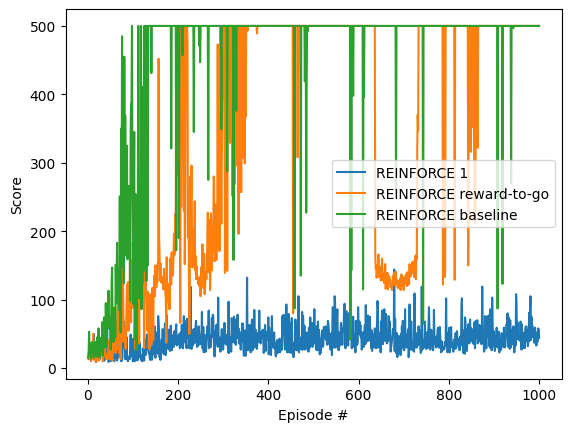

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label='REINFORCE 1')
plt.plot(np.arange(1, len(scores2)+1), scores2, label='REINFORCE reward-to-go')
plt.plot(np.arange(1, len(scores3)+1), scores3, label='REINFORCE baseline')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

### 5. Define the evaluation method

In [60]:
def evaluate_agent(env, max_steps, policy):
    """
    Evaluate the agent
    """
    rewards = []
    for episode in range(10):
        state = env.reset()
        rwd = []
        for t in range(max_steps):
            action, _ = policy.act(state)    
            state, reward, done, _ = env.step(action)
            rwd.append(reward)
            if done:
                break
        rewards.append(sum(rwd))
    return np.mean(rewards), np.std(rewards)

In [61]:
agent_pg = []
agent_rtg = []
agent_baseline = []

agent_pg.append(evaluate_agent(env, 1000, policy_g))
agent_rtg.append(evaluate_agent(env, 1000, policy_rtg))
agent_baseline.append(evaluate_agent(env, 1000, policy_bs))

print('REINFORCE 1: mean={:.2f}, std={:.2f}'.format(agent_pg[0][0], agent_pg[0][1]))
print('REINFORCE 2: mean={:.2f}, std={:.2f}'.format(agent_rtg[0][0], agent_rtg[0][1]))
print('REINFORCE baseline: mean={:.2f}, std={:.2f}'.format(agent_baseline[0][0], agent_baseline[0][1]))

REINFORCE 1: mean=56.20, std=21.86
REINFORCE 2: mean=500.00, std=0.00
REINFORCE baseline: mean=500.00, std=0.00


In [68]:
import pandas as pd

data = {
    'REINFORCE 1': [agent_pg[0][0], agent_pg[0][1]],
    'REINFORCE reward-to-go': [agent_rtg[0][0], agent_rtg[0][1]],
    'REINFORCE baseline': [agent_baseline[0][0], agent_baseline[0][1]]
}

df = pd.DataFrame(data, index=['mean', 'std'])

display(df)

,REINFORCE 1,REINFORCE reward-to-go,REINFORCE baseline
mean,56.200000,500.0,500.0
std,21.862296,0.0,0.0


### 6. Watch the Agent

In [66]:
# Watch REINFORCE agent
from tqdm import tqdm

env = gym.make('CartPole-v1')

state = env.reset()
for t in tqdm(range(1000)):
    action, _ = policy_g.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        state = env.reset()
env.close()


100%|██████████| 1000/1000 [00:20<00:00, 49.25it/s]


In [64]:
# Watch REINFORCE with reward-to-go agent
from tqdm import tqdm

env = gym.make('CartPole-v1')

state = env.reset()
for t in tqdm(range(1000)):
    action, _ = policy_rtg.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        state = env.reset()
env.close()

100%|██████████| 1000/1000 [00:20<00:00, 49.07it/s]


In [65]:
# Watch REINFORCE with baseline agent
from tqdm import tqdm

env = gym.make('CartPole-v1')

state = env.reset()
for t in tqdm(range(1000)):
    action, _ = policy_bs.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        state = env.reset()
env.close()

100%|██████████| 1000/1000 [00:20<00:00, 49.15it/s]
